## POS tagging using modified Viterbi

### Data Preparation

In [1]:
#Importing libraries
import nltk
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

In [2]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [3]:
# train and test data split
random.seed(1234)
train_set,validation_set=train_test_split(nltk_data,test_size=0.05)
print('train_set     :{}'.format(len(train_set)))
print('validation_set:{}'.format(len(validation_set)))
print(train_set[0])

train_set     :3718
validation_set:196
[('``', '.'), ('We', 'PRON'), ('do', 'VERB'), ("n't", 'ADV'), ('think', 'VERB'), ('0', 'X'), ('there', 'DET'), ('is', 'VERB'), ('cause', 'NOUN'), ('for', 'ADP'), ('concern', 'NOUN'), ('at', 'ADP'), ('the', 'DET'), ('moment', 'NOUN'), ('.', '.'), ("''", '.')]


In [4]:
# Getting list of tagged words
train_tagged_words = [train_tup for train_data in train_set for train_tup in train_data]
len(train_tagged_words)

95760

In [5]:
# words or tokens from train set
train_tokens = [train_word[0] for train_word in train_tagged_words]
train_tokens[:10]

['``', 'We', 'do', "n't", 'think', '0', 'there', 'is', 'cause', 'for']

In [6]:
# vocabulary, individual words from train set
train_voc = set(train_tokens)
print(len(train_voc))

12122


In [7]:
# number of individual tags
train_tags = set([train_tag[1] for train_tag in train_tagged_words])
len(train_tags)
print(train_tags)

{'PRON', 'VERB', 'ADP', '.', 'CONJ', 'X', 'NOUN', 'ADV', 'PRT', 'NUM', 'ADJ', 'DET'}


## POS Tagging Algorithm - HMM

### Emission Probabilities

In [8]:
# computing P(w/t) and storing in T x V matrix
t = len(train_tags)
v = len(train_voc)
w_given_t = np.zeros((t, v))

In [9]:
# Function will return No.of words for that tag and No.of times tag appear[compute word given tag : Emission Probability]
def word_given_tag(word,tag,train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    return (count_w_given_tag,count_tag)

In [10]:
# examples

# large
print("large")
print(word_given_tag('large', 'ADJ'))
print(word_given_tag('large', 'VERB'))
print(word_given_tag('large', 'NOUN'), "\n")

# will
print("will")
print(word_given_tag('will', 'VERB'))
print(word_given_tag('will', 'NOUN'), "\n")

# book
print("book")
print(word_given_tag('book', 'NOUN'))
print(word_given_tag('book', 'VERB'), "\n")

# He
print("He")
print(word_given_tag('He', 'NOUN'))
print(word_given_tag('He', 'PRON'), "\n")

# one
print("one")
print(word_given_tag('one', 'NOUN'))
print(word_given_tag('one', 'NUM'))
print(word_given_tag('one', 'ADP'))

large
(27, 6098)
(0, 12876)
(0, 27458) 

will
(270, 12876)
(1, 27458) 

book
(7, 27458)
(1, 12876) 

He
(0, 27458)
(67, 2579) 

one
(9, 27458)
(119, 3409)
(0, 9354)


### Transition Probabilities

In [11]:
# Function will return No.of times tag1 fallowed by tag2 and No.of times tag1 apper 
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [12]:
# examples
print(t2_given_t1('NOUN','ADJ'))
print(t2_given_t1('NOUN','DET'))
print(t2_given_t1('NOUN','VERB'))
print(t2_given_t1('.','NOUN'))
print(t2_given_t1('VERB','NOUN'))

(4271, 6098)
(5279, 8315)
(1416, 12876)
(6596, 27458)
(4049, 27458)


In [13]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DET', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('NOUN', '.'))

(1936, 11156)
(992, 11156)
(2476, 11156)


In [14]:
# creating t x t transition matrix of tags
# each column is t2, each row is t1
# thus M(i,j) represents P(tj given ti)

tags_matrix = np.zeros((len(train_tags), len(train_tags)), dtype='float32')
for i, t1 in enumerate(list(train_tags)):
    for j, t2 in enumerate(list(train_tags)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]
tags_matrix

array([[6.97944919e-03, 4.85071719e-01, 2.28770841e-02, 4.03257087e-02,
        5.42846043e-03, 9.22838300e-02, 2.08995730e-01, 3.48972455e-02,
        1.16324155e-02, 7.75494380e-03, 7.36719668e-02, 1.00814272e-02],
       [3.50264050e-02, 1.69229567e-01, 9.17986929e-02, 3.48710790e-02,
        5.04815159e-03, 2.18157813e-01, 1.09972037e-01, 8.23237002e-02,
        3.12985405e-02, 2.30661705e-02, 6.43056855e-02, 1.34902149e-01],
       [6.85268342e-02, 8.12486652e-03, 1.65704507e-02, 3.95552702e-02,
        8.55249120e-04, 3.52790244e-02, 3.22749615e-01, 1.35770794e-02,
        1.49668590e-03, 6.35022447e-02, 1.04661107e-01, 3.25101554e-01],
       [6.47185370e-02, 8.89207572e-02, 9.10720676e-02, 9.45679471e-02,
        5.76371476e-02, 2.73395479e-02, 2.21943349e-01, 5.26174270e-02,
        2.50986009e-03, 8.15704539e-02, 4.34743650e-02, 1.73538908e-01],
       [5.91798685e-02, 1.51444554e-01, 5.17241396e-02, 3.49487402e-02,
        4.65983234e-04, 8.38769786e-03, 3.53215277e-01, 5.49

In [15]:
# convert the matrix to a df for better readability
tags_df = pd.DataFrame(tags_matrix, columns = list(train_tags), index=list(train_tags))
tags_df

,PRON,VERB,ADP,.,CONJ,X,NOUN,ADV,PRT,NUM,ADJ,DET
PRON,0.006979,0.485072,0.022877,0.040326,0.005428,0.092284,0.208996,0.034897,0.011632,0.007755,0.073672,0.010081
VERB,0.035026,0.169230,0.091799,0.034871,0.005048,0.218158,0.109972,0.082324,0.031299,0.023066,0.064306,0.134902
ADP,0.068527,0.008125,0.016570,0.039555,0.000855,0.035279,0.322750,0.013577,0.001497,0.063502,0.104661,0.325102
.,0.064719,0.088921,0.091072,0.094568,0.057637,0.027340,0.221943,0.052617,0.002510,0.081570,0.043474,0.173539
CONJ,0.059180,0.151445,0.051724,0.034949,0.000466,0.008388,0.353215,0.054986,0.005126,0.040541,0.120690,0.119292
X,0.055724,0.205222,0.144881,0.163509,0.010508,0.073396,0.063366,0.025474,0.182933,0.002866,0.016876,0.055246
NOUN,0.004698,0.147462,0.176160,0.240221,0.042501,0.028880,0.263858,0.017263,0.044031,0.009615,0.012091,0.013220
ADV,0.015172,0.342018,0.118404,0.135884,0.006926,0.023417,0.031332,0.078496,0.014182,0.031992,0.133575,0.068602
PRT,0.018325,0.397579,0.020288,0.042539,0.002291,0.013089,0.247382,0.010144,0.001963,0.058246,0.086387,0.101767
NUM,0.001467,0.017894,0.036081,0.115576,0.013787,0.208566,0.353769,0.002640,0.027867,0.185392,0.033734,0.003227


In [16]:
tags_df.loc['.', :]

PRON    0.064719
VERB    0.088921
ADP     0.091072
.       0.094568
CONJ    0.057637
X       0.027340
NOUN    0.221943
ADV     0.052617
PRT     0.002510
NUM     0.081570
ADJ     0.043474
DET     0.173539
Name: ., dtype: float32

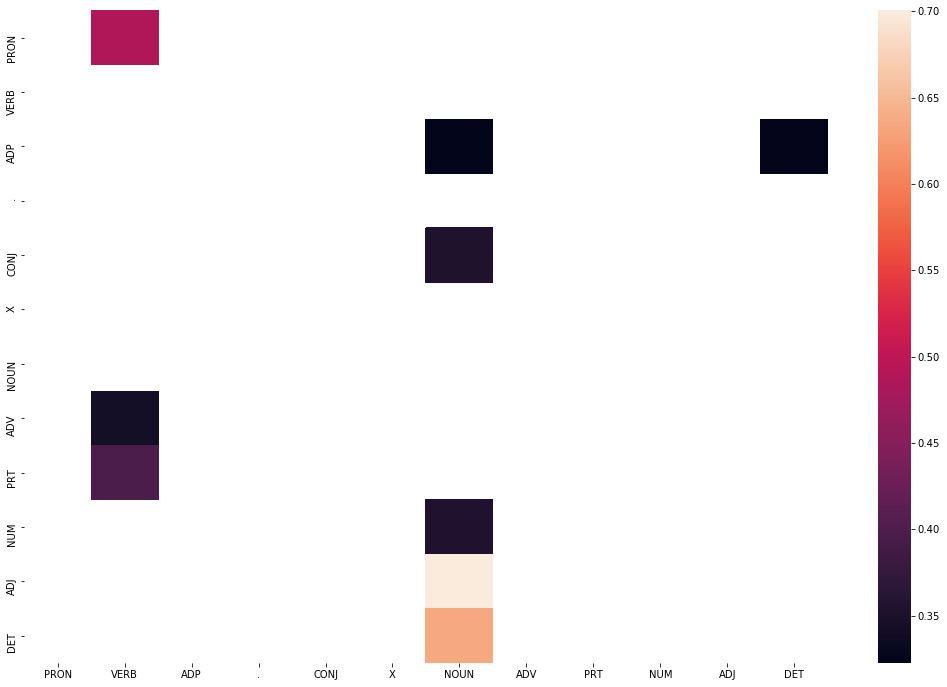

In [17]:
# frequent tags
# filter the df to get P(t2, t1) > 0.3
tags_frequent = tags_df[tags_df>0.3]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Build the vanilla Viterbi based POS tagger

Let's now use the computed probabilities P(w, tag) and P(t2, t1) to assign tags to each word in the document. We'll run through each word w and compute P(tag/w)=P(w/tag).P(tag) for each tag in the tag set, and then assign the tag having the max P(tag/w).<br>

We'll store the assigned tags in a list of tuples, similar to the list 'train_tagged_words'. Each tuple will be a (token, assigned_tag). As we progress further in the list, each tag to be assigned will use the tag of the previous token.<br>

Note: P(tag|start) = P(tag|'.')

In [18]:
len(train_tagged_words)

95760

In [19]:
# Viterbi Heuristic
def viterbi_algo(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
        #print(key)
    return list(zip(words, state))

## Evaluating on Validation Set

In [20]:
# list of tagged words
validation_run_base = [tup for sent in validation_set for tup in sent]

# list of untagged words
validation_tagged_words = [tup[0] for sent in validation_set for tup in sent]
print(len(validation_set))
print(len(validation_tagged_words))

196
4916


In [21]:
# tagging the test sentences
start = time.time()
validation_Viterbi1 = viterbi_algo(validation_tagged_words)
end = time.time()
difference = end-start

In [22]:
print("Time taken in seconds: ", difference)
print(len(validation_tagged_words))

Time taken in seconds:  2898.3681178092957
4916


In [23]:
# accuracy for validation set 
check_acc = [i for i, j in zip(validation_Viterbi1, validation_run_base) if i == j] 
accuracy = (len(check_acc)/len(validation_Viterbi1))*100
print(round(accuracy,2))

91.17


In [24]:
# tags which got wrong prediction from validation set
incorrect_tagged_cases = [[validation_run_base[i-1],j] for i, j in enumerate(zip(validation_Viterbi1, validation_run_base)) if j[0]!=j[1]]
incorrect_tagged_cases

[[('were', 'VERB'), (('more', 'ADV'), ('more', 'ADJ'))],
 [('.', '.'), (('Elisa', 'PRON'), ('Elisa', 'NOUN'))],
 [('Elisa', 'NOUN'), (('Hollis', 'PRON'), ('Hollis', 'NOUN'))],
 [('as', 'ADP'), (('Norwest', 'PRON'), ('Norwest', 'NOUN'))],
 [('market-share', 'ADJ'), (('battles', 'PRON'), ('battles', 'NOUN'))],
 [('on', 'ADP'), (('50.1', 'PRON'), ('50.1', 'NUM'))],
 [('your', 'PRON'), (('gut', 'PRON'), ('gut', 'NOUN'))],
 [('Ms.', 'NOUN'), (('Kirkpatrick', 'PRON'), ('Kirkpatrick', 'NOUN'))],
 [(',', '.'), (('more', 'ADV'), ('more', 'ADJ'))],
 [('that', 'ADP'), (('present', 'VERB'), ('present', 'ADJ'))],
 [('an', 'DET'), (('individual', 'ADJ'), ('individual', 'NOUN'))],
 [('stock', 'NOUN'), (('indexes', 'PRON'), ('indexes', 'NOUN'))],
 [('the', 'DET'), (('underlying', 'ADJ'), ('underlying', 'VERB'))],
 [('a', 'DET'), (('stock-index', 'ADJ'), ('stock-index', 'NOUN'))],
 [('rose', 'VERB'), (('87.5', 'PRON'), ('87.5', 'NUM'))],
 [('$', '.'), (('38.875', 'PRON'), ('38.875', 'NUM'))],
 [('misde

In [25]:
# Testing on sentance from the test data provided
test_data="""Android is a mobile operating system developed by Google.
Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.
Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose.
Twitter is an online news and social networking service on which users post and interact with messages known as tweets.
Before entering politics, Donald Trump was a domineering businessman and a television personality.
The 2018 FIFA World Cup is the 21st FIFA World Cup, an international football tournament contested once every four years.
This is the first World Cup to be held in Eastern Europe and the 11th time that it has been held in Europe.
Show me the cheapest round trips from Dallas to Atlanta
I would like to see flights from Denver to Philadelphia.
Show me the price of the flights leaving Atlanta at about 3 in the afternoon and arriving in San Francisco.
NASA invited social media users to experience the launch of ICESAT-2 Satellite."""

In [26]:
test_words = word_tokenize(test_data)
start = time.time()
test_Viterbi = viterbi_algo(test_words)
end = time.time()
difference = end-start

In [27]:
print("Time taken in seconds: ", difference)
print(len(test_words))

Time taken in seconds:  109.84571814537048
181


In [28]:
# Test data tagged as below
test_Viterbi

[('Android', 'PRON'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'PRON'),
 ('.', '.'),
 ('Android', 'PRON'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'PRON'),
 ('worldwide', 'PRON'),
 ('on', 'ADP'),
 ('smartphones', 'PRON'),
 ('since', 'ADP'),
 ('2011', 'PRON'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'PRON'),
 ('.', '.'),
 ('Google', 'PRON'),
 ('and', 'CONJ'),
 ('Twitter', 'PRON'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'PRON'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'PRON'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'PRON'),
 ("'s", 'VERB'),
 ('firehose', 'PRON'),
 ('.', '.'),
 ('Twitter', 'PRON'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'PRON'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),


#### With vanilla Viterbi we got 91.89% accuracy we can increase accuracy

### Solve the problem of unknown words

### Modification 1

State probability is dependent only on transition probability for the unknown words

In [29]:
# state probability is dependent only on transition probability
def viterbi_algo_1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            
            if word in train_voc:
                state_probability = transition_p * emission_p              
            else:
                state_probability = transition_p
            
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))

In [30]:
# validation set 
validation_Viterbimodf1 = viterbi_algo_1(validation_tagged_words)

In [31]:
# accuracy for validation data set
check_modf1 = [i for i, j in zip(validation_Viterbimodf1, validation_run_base) if i == j] 
accuracy = (len(check_modf1)/len(validation_Viterbimodf1))*100
round(accuracy,2)

93.9

In [32]:
start = time.time()
tagged_seq1_test = viterbi_algo_1(test_words)
end = time.time()
difference = end-start
print(difference)
tagged_seq1_test

46.921921730041504


[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'DET'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'DET'),
 ('since', 'ADP'),
 ('2011', 'DET'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'DET'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'DET'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'X'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'VERB'),
 ("'s", 'PRT'),
 ('firehose', 'VERB'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('servic

#### State probability is dependent only on transition probability for the unknown words modification got 93.9% 

## Modification 2

#### All unknown words are replaced by Noun, It is most misplaced tag

In [33]:
# All unknown words are replaced by Noun 

def viterbi_algo_2(test_words, train_bag = train_tagged_words):
    tagged_seq = viterbi_algo(test_words)
    V = list(set([pair[0] for pair in train_bag]))
    
    words = [pair[0] for pair in tagged_seq]
    Viterbi_tags = [pair[1] for pair in tagged_seq]
    
    for key, word in enumerate(words):
        if word not in V:
            Viterbi_tags[key] = 'NOUN'
            
    
    return list(zip(words, Viterbi_tags))

In [34]:
# validation set 
start = time.time()
validation_Viterbimodf2 = viterbi_algo_2(validation_tagged_words)
end = time.time()
difference2 = end-start
print(difference2)

1315.3244354724884


In [35]:
# accuracy for validation data set
check_modf1 = [i for i, j in zip(validation_Viterbimodf2, validation_run_base) if i == j] 
accuracy = (len(check_modf1)/len(validation_Viterbimodf2))*100
round(accuracy,2)

93.98

In [36]:
start = time.time()
tagged_seq2_test = viterbi_algo_2(test_words)
end = time.time()
difference = end-start
print(difference)
tagged_seq2_test

77.28436827659607


[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google', 'NOUN'),
 ('.', '.'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'NOUN'),
 ('since', 'ADP'),
 ('2011', 'NOUN'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013', 'NOUN'),
 ('.', '.'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NOUN'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ('Twitter', 'NOUN'),
 ("'s", 'VERB'),
 ('firehose', 'NOUN'),
 ('.', '.'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),


#### All unknown words are replaced by Noun, It is most misplaced tag modification got 93.98% accuracy

## Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm¶

With vanilla Viterbi we got                                          --> 91.89% accuracy<br>
State probability is dependent only on transition probability we got --> 93.90% accuracy<br>
All unknown words are replaced by Noun we got                        --> 93.98% accuracy

#### When we replace all unknow words to Noun we get high accuracy.

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

| WORD    | POS TAGGER | UNKNOW WORDS BY NOUN |
|---------|------------|----------------------|
| Google  | PRON       | NOUN                 |
| Android | PRON       | NOUN                 |
| Twitter | PRON       | NOUN                 |

If we observe above words like Goolge,Android and Twitter POS tagger misplaced there tags and Modification we tagged unknown words with NOUN it got 2% high accuracy.